In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA Available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS Available")
else:
    device = torch.device("cpu")
    print("Using CPU")

MPS Available


In [3]:

# train_transforms = transforms.Compose([
#     transforms.RandomRotation((-7., 7.), fill=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
# ])

# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

train_transforms = transforms.Compose([
                        transforms.RandomAffine(degrees=7, translate=(0.08, 0.08)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomErasing(p=0.05, scale=(0.02, 0.05), ratio=(0.3, 3.3))  # tiny, optional
                        ])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [12]:
# Data loaders
batch_size = 128
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

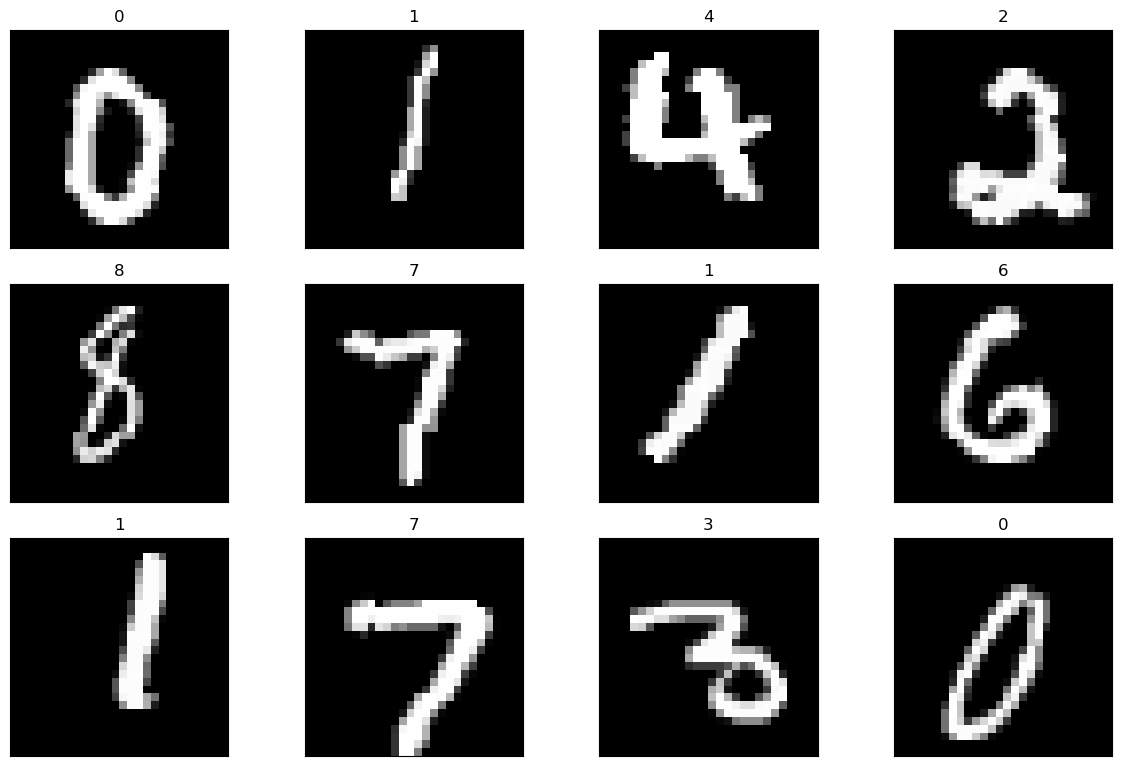

In [19]:
# Visualize some training samples
def visualize_batch():
    batch_data, batch_label = next(iter(train_loader))
    fig = plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap='gray')
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])
    plt.show()

visualize_batch()

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Drastically reduced channels to meet <25K constraint
        self.conv1 = nn.Conv2d(1, 14, kernel_size=3, bias=True)  # (3*3*1 + 1) * 8 = 80  584.   
        self.bn1 = nn.BatchNorm2d(14)  # 16

        self.conv2 = nn.Conv2d(14, 18, kernel_size=3, bias=True)  # (3*3*8 + 1) * 16 = 1,168 2320
        self.bn2 = nn.BatchNorm2d(18)  # 32

        # self.conv3 = nn.Conv2d(14, 20, kernel_size=3,  bias=True)  # (3*3*16 + 1) * 24 = 3,480 6944
        # self.bn3 = nn.BatchNorm2d(20)  # 48

        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(18, 18, kernel_size=3, bias=True)  # (3*3*24 + 1) * 32 = 6,944 11560
        self.bn4 = nn.BatchNorm2d(18)  # 64
        self.conv5 = nn.Conv2d(18, 24, kernel_size=3, bias=True)  # 14x14
        self.bn5 = nn.BatchNorm2d(24)
        self.pool2 = nn.MaxPool2d(2, 2)  # 14->7

        self.conv6 = nn.Conv2d(24, 24, kernel_size=3, padding=1, bias=True)  # 7x7
        self.bn6 = nn.BatchNorm2d(24)
        self.conv7 = nn.Conv2d(24, 24, kernel_size=3, bias=True)  # 7x7
        self.bn7 = nn.BatchNorm2d(24)

        #self.classifier = nn.Conv2d(26, 10, kernel_size=1, bias=True)  # 7x7 -> 1x1

        # self.conv4 = nn.Conv2d(32, 40, kernel_size=3)  # (3*3*32 + 1) * 40 = 6,944 11560
        # self.bn4 = nn.BatchNorm2d(40)  # 64

        # After convolutions: 32 * 1 * 1 = 32

        # self.fc1 = nn.Linear(26*2*2, 16)  # (32 + 1) * 24 = 792. 1312
        # self.dropout = nn.Dropout(0.1)
        # self.fc2 = nn.Linear(16, 10)  # (24 + 1) * 10 = 250 330

        self.gap  = nn.AdaptiveAvgPool2d(1)   # add this
        self.fc   = nn.Linear(24, 10)         # replace fc1/fc2 head

        # Total: 80 + 16 + 1,168 + 32 + 3,480 + 48 + 6,944 + 64 + 792 + 250 = 12,874 parameters

        #self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        # x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool2(x)

        x = F.relu(self.bn6(self.conv6(x)))  # 5x5 -> 3x3
        x = F.relu(self.bn7(self.conv7(x)))  # 5x5 -> 3x3

        # x = F.adaptive_avg_pool2d(x, 1)           # (N, 26, 1, 1)
        # x = self.classifier(x)  # (N, num_classes)
        #x = x.view(-1, 26)
        # x = x.view(x.size(0), -1) 
        # x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = self.fc2(x)

        x = self.gap(x)                             # (N, 26, 1, 1)
        x = torch.flatten(x, 1)                     # (N, 26) — SAFE (never drops batch)
        x = self.fc(x)                              # (N, 10)
        #return F.log_softmax(x, dim=1)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [15]:
# Training and testing functions
train_losses = []
test_losses = []
train_acc = []
test_acc = []
model = Net().to(device)  # Using improved model
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [16]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion, epoch, scheduler=None):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        pred = model(data)
        loss = criterion(pred, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Epoch {epoch} | Loss={loss.item():0.4f} | Acc={100*correct/processed:0.2f}%')

    train_accuracy = 100*correct/processed
    train_acc.append(train_accuracy)
    train_losses.append(train_loss/len(train_loader))

    print(f'\nTraining - Epoch {epoch}:')
    print(f'  Accuracy: {correct}/{processed} ({train_accuracy:.2f}%)')
    print(f'  Avg Loss: {train_loss/len(train_loader):.4f}')

    return train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * len(data)
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_acc.append(accuracy)
    test_losses.append(test_loss)

    print(f'Test Results:')
    print(f'  Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    print(f'  Avg Loss: {test_loss:.4f}')

    return accuracy

In [17]:
# Training setup
from torch.optim.lr_scheduler import OneCycleLR
total_params = model.count_parameters()
print(f"\nModel Parameters: {total_params:,}")
print(f"Model Architecture:")
print(model)
print("="*50 + "\n")

# Use AdamW for better regularization with small models
optimizer = optim.AdamW(model.parameters(), lr=0.006, weight_decay=1e-6)
print(f"Optimizer: AdamW (lr=0.008, weight_decay=1e-6)")


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
num_epochs = 20
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.02,                        # try 0.008–0.02; 0.01 is a good start
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,                      # warmup portion
    div_factor=10, final_div_factor=100
)



print(f"Loss: CrossEntropyLoss")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Training Samples: {len(train_data):,}")
print(f"Test Samples: {len(test_data):,}")
print("="*60 + "\n")

# Training loop
print("Starting training...")
best_test_acc = 0

for epoch in range(1, num_epochs+1):
    # Train
    train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch, scheduler)

    # Test
    test_accuracy = test(model, device, test_loader, criterion)
    # if test_accuracy > best_acc:
    #     best_acc = test_accuracy
    #     best_state = {k: v.cpu() for k, v in model.state_dict().items()}
# after training:
# if best_state is not None:
#     model.load_state_dict(best_state)



Model Parameters: 20,182
Model Architecture:
Net(
  (conv1): Conv2d(1, 14, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(14, 18, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): C

  0%|          | 0/469 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1 | Loss=0.3693 | Acc=94.34%: 100%|██████████| 469/469 [00:11<00:00, 39.32it/s] 



Training - Epoch 1:
  Accuracy: 56606/60000 (94.34%)
  Avg Loss: 0.5444
Test Results:
  Accuracy: 9861/10000 (98.61%)
  Avg Loss: 0.3425


Epoch 2 | Loss=0.3474 | Acc=98.24%: 100%|██████████| 469/469 [00:06<00:00, 70.78it/s]



Training - Epoch 2:
  Accuracy: 58943/60000 (98.24%)
  Avg Loss: 0.3556
Test Results:
  Accuracy: 9884/10000 (98.84%)
  Avg Loss: 0.3294


Epoch 3 | Loss=0.3421 | Acc=98.39%: 100%|██████████| 469/469 [00:06<00:00, 73.05it/s]



Training - Epoch 3:
  Accuracy: 59031/60000 (98.39%)
  Avg Loss: 0.3471
Test Results:
  Accuracy: 9907/10000 (99.07%)
  Avg Loss: 0.3294


Epoch 4 | Loss=0.3491 | Acc=98.58%: 100%|██████████| 469/469 [00:06<00:00, 73.15it/s]



Training - Epoch 4:
  Accuracy: 59146/60000 (98.58%)
  Avg Loss: 0.3396
Test Results:
  Accuracy: 9924/10000 (99.24%)
  Avg Loss: 0.3195


Epoch 5 | Loss=0.3153 | Acc=98.72%: 100%|██████████| 469/469 [00:06<00:00, 73.66it/s]



Training - Epoch 5:
  Accuracy: 59231/60000 (98.72%)
  Avg Loss: 0.3328
Test Results:
  Accuracy: 9931/10000 (99.31%)
  Avg Loss: 0.3132


Epoch 6 | Loss=0.3694 | Acc=98.93%: 100%|██████████| 469/469 [00:06<00:00, 73.09it/s]



Training - Epoch 6:
  Accuracy: 59356/60000 (98.93%)
  Avg Loss: 0.3258
Test Results:
  Accuracy: 9936/10000 (99.36%)
  Avg Loss: 0.3139


Epoch 7 | Loss=0.3297 | Acc=98.93%: 100%|██████████| 469/469 [00:06<00:00, 74.58it/s] 



Training - Epoch 7:
  Accuracy: 59357/60000 (98.93%)
  Avg Loss: 0.3259
Test Results:
  Accuracy: 9948/10000 (99.48%)
  Avg Loss: 0.3088


Epoch 8 | Loss=0.3139 | Acc=99.02%: 100%|██████████| 469/469 [00:06<00:00, 73.11it/s]



Training - Epoch 8:
  Accuracy: 59409/60000 (99.02%)
  Avg Loss: 0.3216
Test Results:
  Accuracy: 9940/10000 (99.40%)
  Avg Loss: 0.3076


Epoch 9 | Loss=0.3567 | Acc=99.14%: 100%|██████████| 469/469 [00:06<00:00, 73.46it/s]



Training - Epoch 9:
  Accuracy: 59485/60000 (99.14%)
  Avg Loss: 0.3181
Test Results:
  Accuracy: 9928/10000 (99.28%)
  Avg Loss: 0.3086


Epoch 10 | Loss=0.3146 | Acc=99.17%: 100%|██████████| 469/469 [00:06<00:00, 73.91it/s]



Training - Epoch 10:
  Accuracy: 59504/60000 (99.17%)
  Avg Loss: 0.3164
Test Results:
  Accuracy: 9948/10000 (99.48%)
  Avg Loss: 0.3044


Epoch 11 | Loss=0.3671 | Acc=99.15%: 100%|██████████| 469/469 [00:06<00:00, 71.44it/s]



Training - Epoch 11:
  Accuracy: 59492/60000 (99.15%)
  Avg Loss: 0.3155
Test Results:
  Accuracy: 9944/10000 (99.44%)
  Avg Loss: 0.3048


Epoch 12 | Loss=0.3145 | Acc=99.29%: 100%|██████████| 469/469 [00:06<00:00, 74.31it/s] 



Training - Epoch 12:
  Accuracy: 59576/60000 (99.29%)
  Avg Loss: 0.3116
Test Results:
  Accuracy: 9937/10000 (99.37%)
  Avg Loss: 0.3044


Epoch 13 | Loss=0.3032 | Acc=99.30%: 100%|██████████| 469/469 [00:06<00:00, 73.55it/s]



Training - Epoch 13:
  Accuracy: 59582/60000 (99.30%)
  Avg Loss: 0.3097
Test Results:
  Accuracy: 9959/10000 (99.59%)
  Avg Loss: 0.2995


Epoch 14 | Loss=0.3058 | Acc=99.38%: 100%|██████████| 469/469 [00:06<00:00, 73.15it/s]



Training - Epoch 14:
  Accuracy: 59630/60000 (99.38%)
  Avg Loss: 0.3074
Test Results:
  Accuracy: 9958/10000 (99.58%)
  Avg Loss: 0.2991


Epoch 15 | Loss=0.3046 | Acc=99.43%: 100%|██████████| 469/469 [00:06<00:00, 73.03it/s]



Training - Epoch 15:
  Accuracy: 59658/60000 (99.43%)
  Avg Loss: 0.3055
Test Results:
  Accuracy: 9953/10000 (99.53%)
  Avg Loss: 0.2996


Epoch 16 | Loss=0.2953 | Acc=99.46%: 100%|██████████| 469/469 [00:06<00:00, 73.57it/s]



Training - Epoch 16:
  Accuracy: 59675/60000 (99.46%)
  Avg Loss: 0.3050
Test Results:
  Accuracy: 9955/10000 (99.55%)
  Avg Loss: 0.2989


Epoch 17 | Loss=0.2905 | Acc=99.55%: 100%|██████████| 469/469 [00:06<00:00, 72.64it/s]



Training - Epoch 17:
  Accuracy: 59729/60000 (99.55%)
  Avg Loss: 0.3023
Test Results:
  Accuracy: 9955/10000 (99.55%)
  Avg Loss: 0.2979


Epoch 18 | Loss=0.2979 | Acc=99.57%: 100%|██████████| 469/469 [00:06<00:00, 72.92it/s]



Training - Epoch 18:
  Accuracy: 59743/60000 (99.57%)
  Avg Loss: 0.3006
Test Results:
  Accuracy: 9958/10000 (99.58%)
  Avg Loss: 0.2972


Epoch 19 | Loss=0.2866 | Acc=99.59%: 100%|██████████| 469/469 [00:06<00:00, 73.49it/s]



Training - Epoch 19:
  Accuracy: 59752/60000 (99.59%)
  Avg Loss: 0.3003
Test Results:
  Accuracy: 9956/10000 (99.56%)
  Avg Loss: 0.2966


Epoch 20 | Loss=0.2945 | Acc=99.62%: 100%|██████████| 469/469 [00:06<00:00, 73.44it/s]



Training - Epoch 20:
  Accuracy: 59770/60000 (99.62%)
  Avg Loss: 0.2993
Test Results:
  Accuracy: 9959/10000 (99.59%)
  Avg Loss: 0.2970


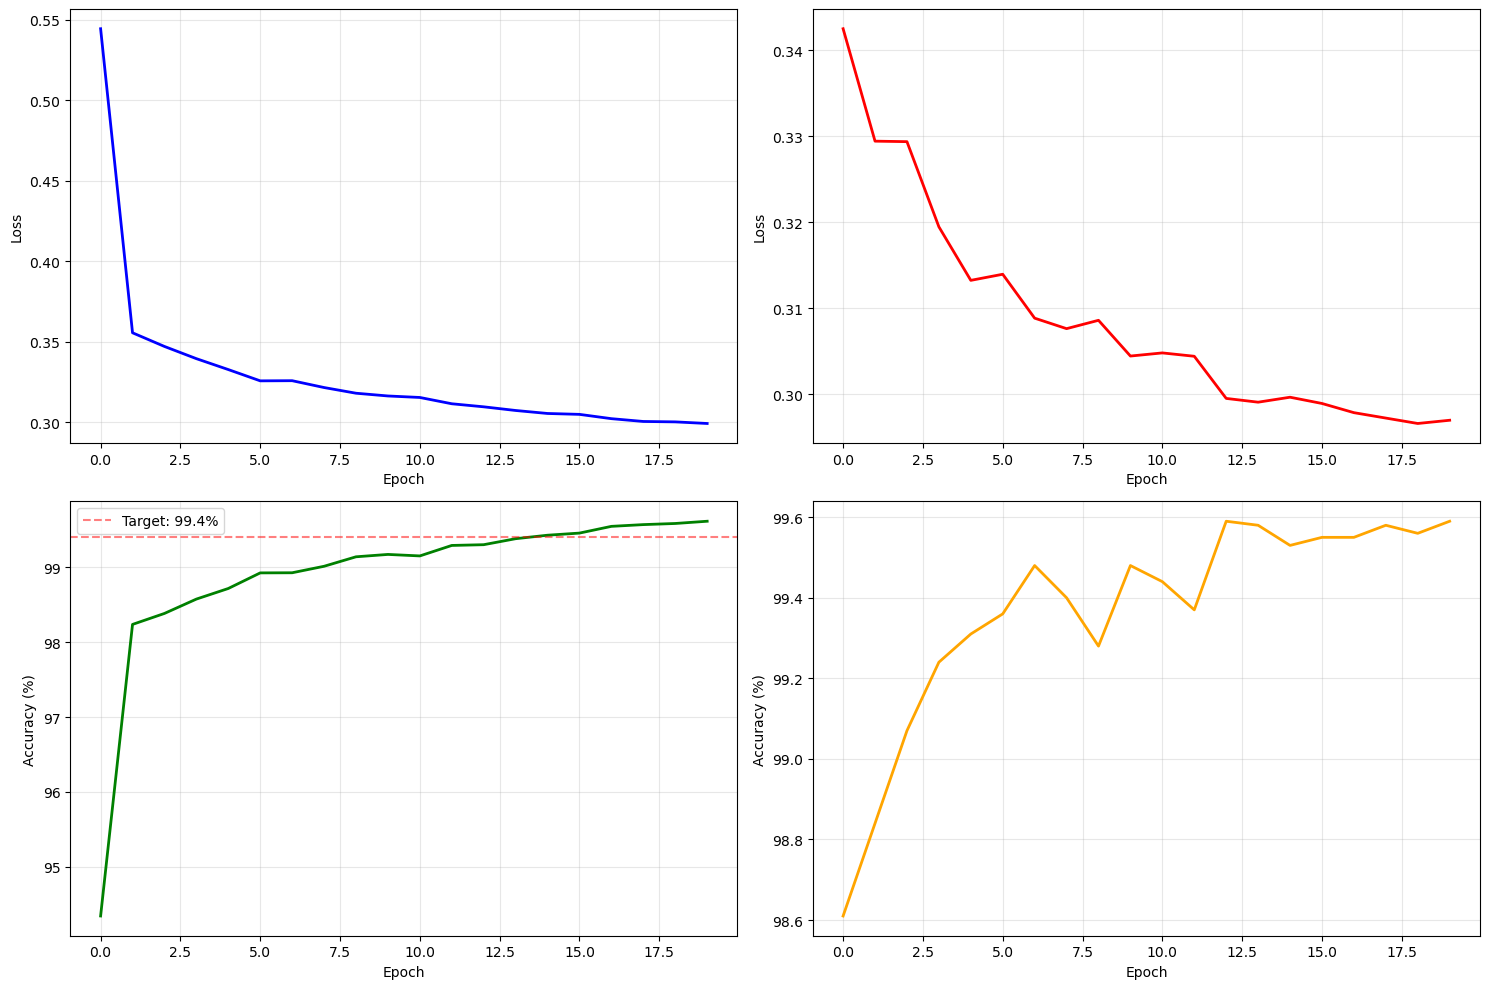


Model Parameters: 20,182 (< 25,000 ✓)
Final Training Accuracy: 99.62%
Final Test Accuracy: 99.59%
Best Test Accuracy: 0.00%
First Epoch Training Accuracy: 94.34%

⚠ First epoch accuracy was 94.34% (target was 99.4%)
  Tips to improve:
  - Try the LightweightNet or UltraLightNet models
  - Increase learning rate slightly
  - Use smaller batch size for more updates


In [20]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
axs[0, 0].plot(train_losses, 'b-', linewidth=2)
#axs[0, 0].set_title(f"Training Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True, alpha=0.3)

# Training Accuracy
axs[1, 0].plot(train_acc, 'g-', linewidth=2)
#axs[1, 0].set_title(f"Training Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy (%)")
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].axhline(y=99.4, color='r', linestyle='--', alpha=0.5, label='Target: 99.4%')
axs[1, 0].legend()

# Test Loss
axs[0, 1].plot(test_losses, 'r-', linewidth=2)
#axs[0, 1].set_title(f"Test Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].grid(True, alpha=0.3)

# Test Accuracy
axs[1, 1].plot(test_acc, 'orange', linewidth=2)
#axs[1, 1].set_title(f"Test Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy (%)")
axs[1, 1].grid(True, alpha=0.3)

#plt.suptitle(f"Training Results - {model_name} ({total_params:,} parameters)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Final summary
print(f"\n{'='*60}")
#print(f"FINAL SUMMARY - {model_name}")
print(f"{'='*60}")
print(f"Model Parameters: {total_params:,} (< 25,000 ✓)")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"First Epoch Training Accuracy: {train_acc[0]:.2f}%")

if train_acc[0] >= 99.4:
    print(f"\n✓ SUCCESS: Achieved {train_acc[0]:.2f}% training accuracy in first epoch!")
else:
    print(f"\n⚠ First epoch accuracy was {train_acc[0]:.2f}% (target was 99.4%)")
    print("  Tips to improve:")
    print("  - Try the LightweightNet or UltraLightNet models")
    print("  - Increase learning rate slightly")
    print("  - Use smaller batch size for more updates")

print(f"{'='*60}")